In [1]:
!pip install tensorflow
!pip install yfinance

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/e4/14/d795bb156f8cc10eb1dcfe1332b7dbb8405b634688980aa9be8f885cc888/tensorflow-2.16.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.16.1 from https://files.pythonhosted.org/packages/e0/36/6278e4e7e69a90c00e0f82944d8f2713dd85a69d1add455d9e50446837ab/tensorflow_intel-2.16.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb792fbcf0c653af6076b81e5941d36ec61f7ce6028/astunparse-1.6.3-py2.py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/41/f0/7e988a019bc54b2db

[*********************100%%**********************]  1 of 1 completed


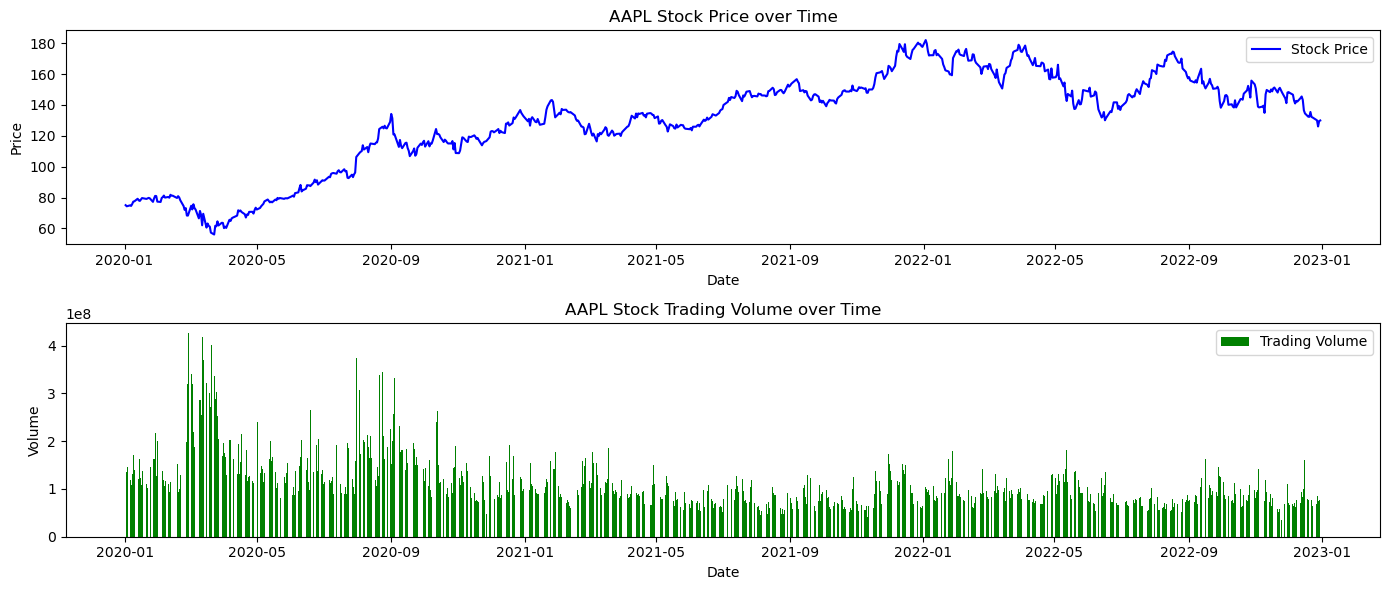

Correlation between daily price changes and volume changes: -0.04


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# Fetch historical data for Apple stock from Yahoo Finance
ticker = "AAPL"
df = yf.download(ticker, start="2020-01-01", end="2023-01-01")  # you can adjust the start and end dates

# Plot stock price over time
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(df['Close'], label="Stock Price", color="blue")
plt.title(f"{ticker} Stock Price over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()

# Plot stock volume over time
plt.subplot(2, 1, 2)
plt.bar(df.index, df['Volume'], label="Trading Volume", color="green")
plt.title(f"{ticker} Stock Trading Volume over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()

plt.tight_layout()
plt.show()

# Calculate the daily changes in stock price and volume
df['Price Change'] = df['Close'].pct_change()
df['Volume Change'] = df['Volume'].pct_change()

# Calculate correlation between price changes and volume changes
correlation = df['Price Change'].corr(df['Volume Change'])

print(f"Correlation between daily price changes and volume changes: {correlation:.2f}")


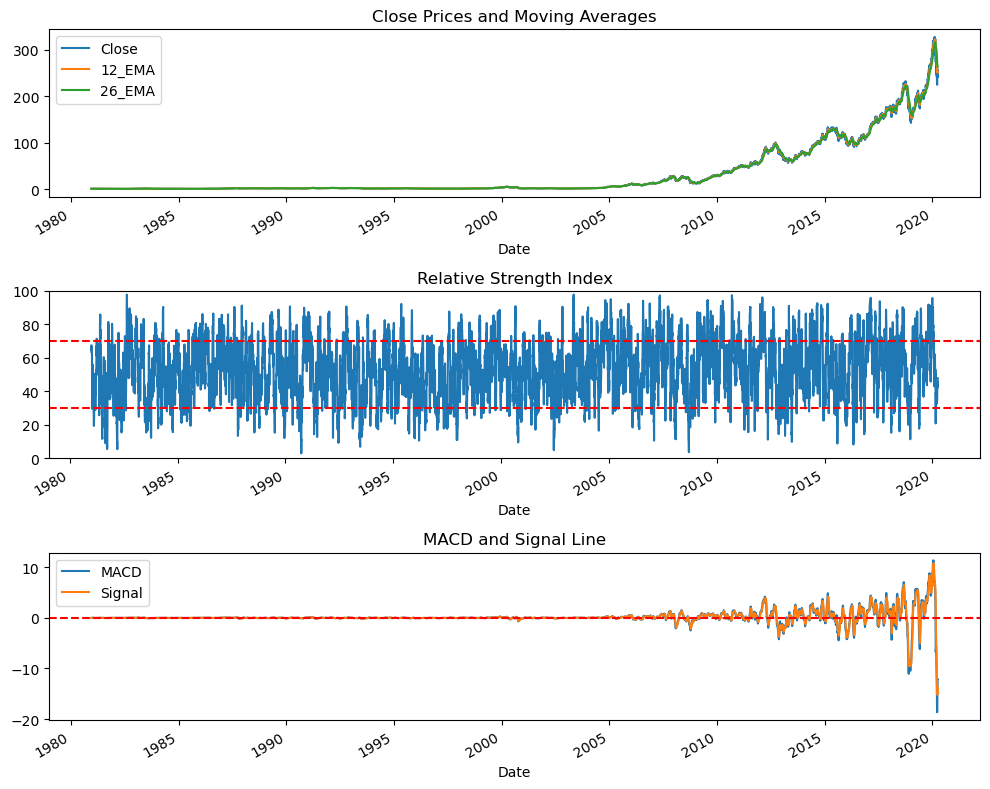

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Reading the CSV data
data = pd.read_csv('AAPL.csv', parse_dates=['Date'], index_col='Date')

# Calculate RSI
def compute_RSI(data, window):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

data['RSI'] = compute_RSI(data, 14)

# Calculate MACD
data['12_EMA'] = data['Close'].ewm(span=12, adjust=False).mean()
data['26_EMA'] = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['12_EMA'] - data['26_EMA']
data['Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

# Plotting
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,8))

# Plotting Close prices and Moving averages
data[['Close', '12_EMA', '26_EMA']].plot(ax=axes[0])
axes[0].set_title('Close Prices and Moving Averages')

# Plotting RSI
data['RSI'].plot(ax=axes[1], ylim=[0, 100])
axes[1].axhline(70, color='r', linestyle='dashed')
axes[1].axhline(30, color='r', linestyle='dashed')
axes[1].set_title('Relative Strength Index')

# Plotting MACD
data[['MACD', 'Signal']].plot(ax=axes[2])
axes[2].axhline(0, color='r', linestyle='dashed')
axes[2].set_title('MACD and Signal Line')

plt.tight_layout()
plt.show()


In [4]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


def stock_predict(train_start_date, train_end_date, ticker, ax):
    # Customized dates for training dataset
    df = yf.download(ticker, start=train_start_date, end="2025-01-01")
    
    # Get company name from yfinance
    company_info = yf.Ticker(ticker)
    company_name = company_info.info['shortName']

    # Preprocess data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

    # Training
    training_data_len = len(df.loc[:train_end_date])  # Use user-defined end date for training
    train_data = scaled_data[0:training_data_len, :]
    x_train, y_train = [], []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size=1, epochs=1)

    # Test data preparation
    test_data = scaled_data[training_data_len - 60:, :]
    x_test, y_test = [], df['Close'][training_data_len:].values
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Predictions
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # Plot
    ax.set_title(f'{company_name}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price $')
    ax.plot(df['Close'][:training_data_len], label='Train')
    ax.plot(df.index[training_data_len:], df['Close'][training_data_len:], label='Val')
    ax.plot(df.index[training_data_len:], predictions, label='Predictions', color='orange')
    ax.legend(loc='lower right')
    ax.grid(True)


[*********************100%%**********************]  1 of 1 completed
D:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0857
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[*********************100%%**********************]  1 of 1 completed
D:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0469
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


[*********************100%%**********************]  1 of 1 completed
D:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0432
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


[*********************100%%**********************]  1 of 1 completed
D:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0096
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


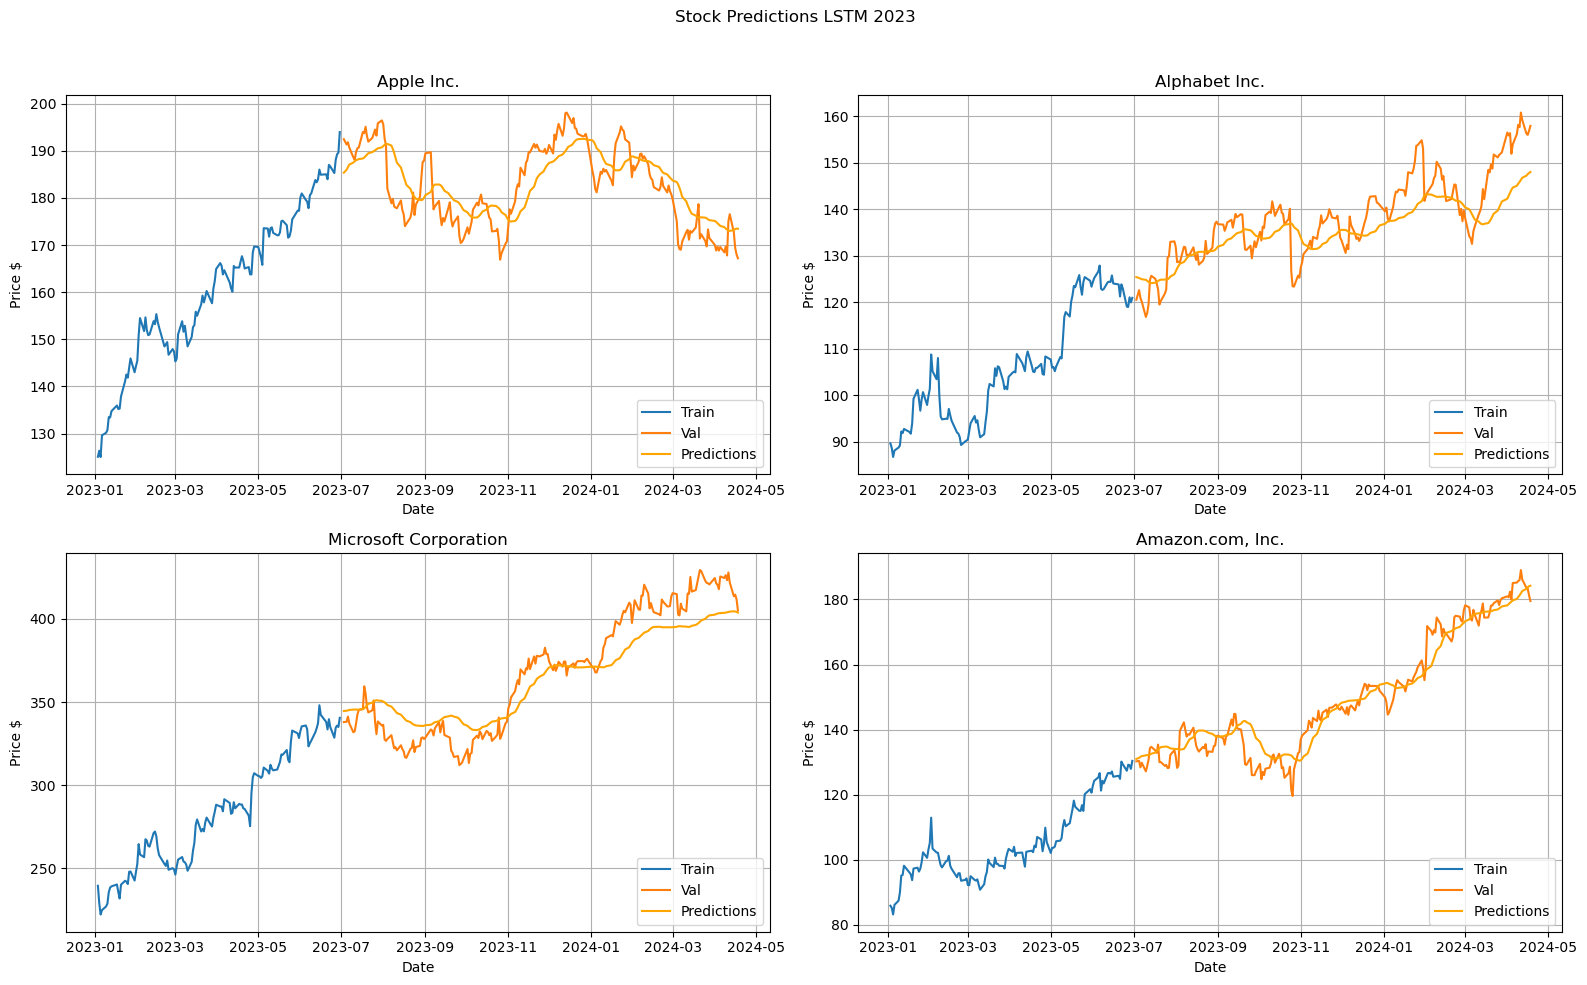

In [5]:
tickers = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Stock Predictions LSTM 2023')

tickers = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
for i, ticker in enumerate(tickers):
    row = i // 2
    col = i % 2
    stock_predict("2023-01-01", "2023-06-30", ticker, axes[row, col])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


[*********************100%%**********************]  1 of 1 completed
D:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1323/1323 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 0.0069
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[*********************100%%**********************]  1 of 1 completed
D:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1323/1323 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - loss: 0.0124
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


[*********************100%%**********************]  1 of 1 completed
D:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1323/1323 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 0.0081
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[*********************100%%**********************]  1 of 1 completed
D:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1323/1323 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - loss: 0.0087
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


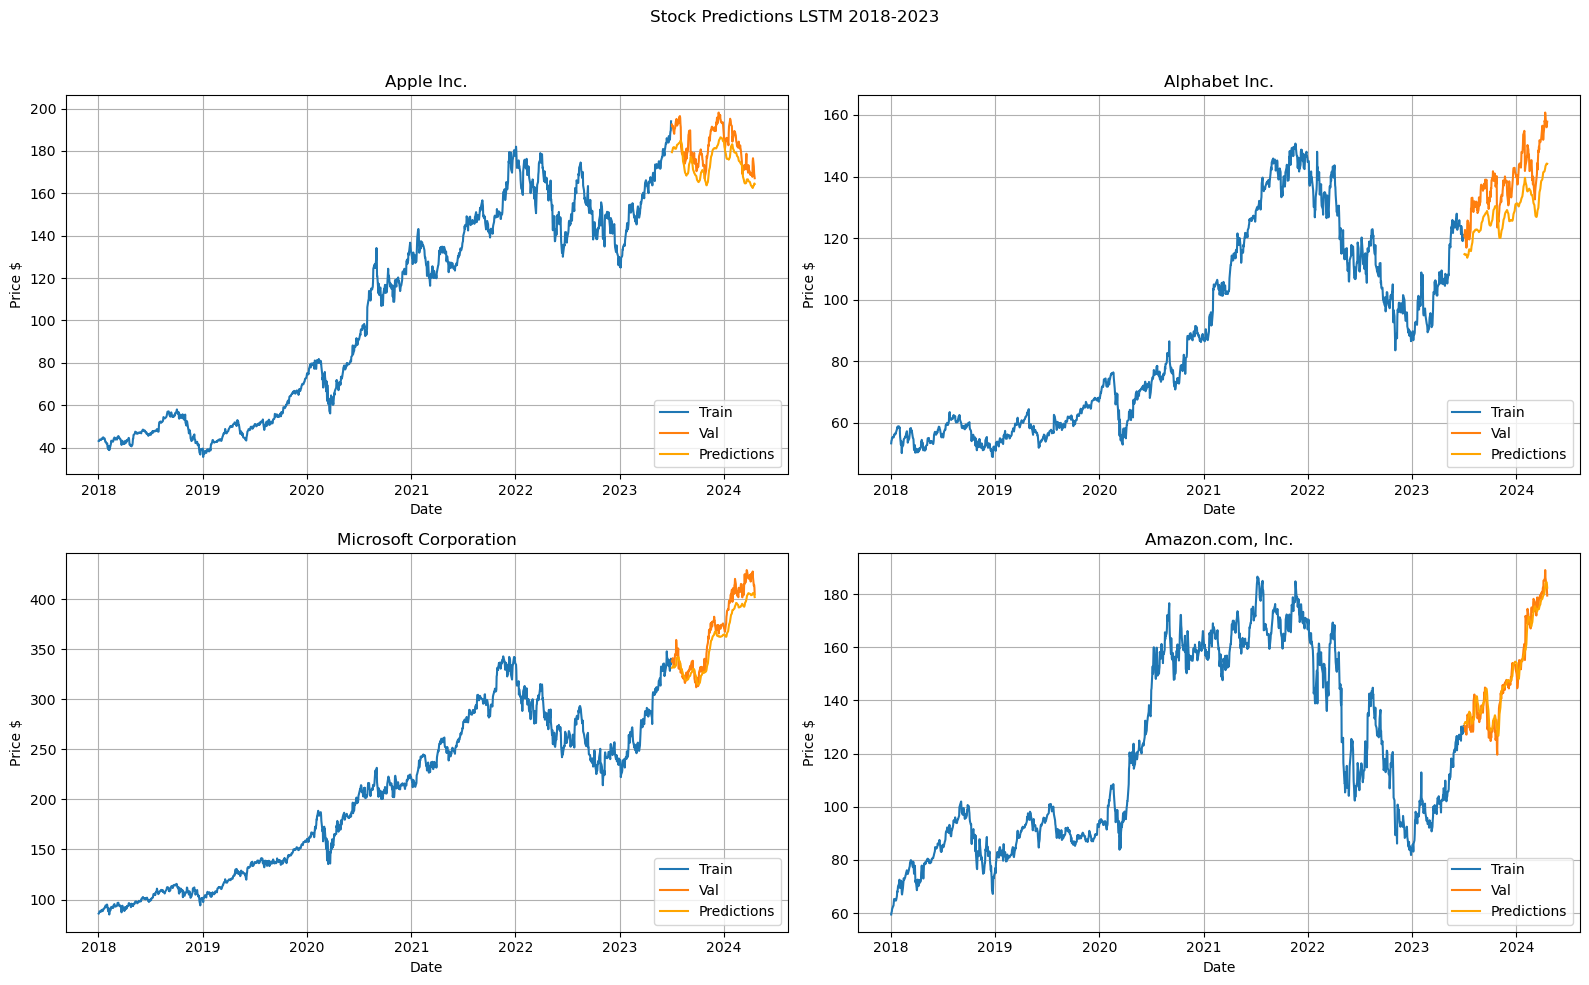

In [6]:
tickers = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Stock Predictions LSTM 2018-2023')

tickers = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
for i, ticker in enumerate(tickers):
    row = i // 2
    col = i % 2
    stock_predict("2018-01-01", "2023-06-30", ticker, axes[row, col])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the layout to make room for the main title
plt.show()


In [7]:
from keras.layers import GRU
def stock_predict_GRU(train_start_date, train_end_date, ticker, company_name, ax):
    # Customized dates for training dataset
    df = yf.download(ticker, start=train_start_date, end="2024-01-01")

    # Preprocess data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

    # Training
    training_data_len = len(df.loc[:train_end_date])  # Use user-defined end date for training
    train_data = scaled_data[0:training_data_len, :]
    x_train, y_train = [], []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # GRU model
    model = Sequential()
    model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(GRU(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size=1, epochs=1)

    # Test data preparation
    test_data = scaled_data[training_data_len - 60:, :]
    x_test, y_test = [], df['Close'][training_data_len:].values
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Predictions
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # Plot
    ax.set_title(f'Model for {ticker}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price $')
    ax.plot(df['Close'][:training_data_len], label='Train')
    ax.plot(df.index[training_data_len:], df['Close'][training_data_len:], label='Val')
    ax.plot(df.index[training_data_len:], predictions, label='Predictions', color='orange')
    ax.legend(loc='lower right')
    ax.grid(True)

[*********************100%%**********************]  1 of 1 completed
D:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1402
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step


[*********************100%%**********************]  1 of 1 completed
D:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0640
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


[*********************100%%**********************]  1 of 1 completed
D:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0705
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


[*********************100%%**********************]  1 of 1 completed
D:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0531
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step


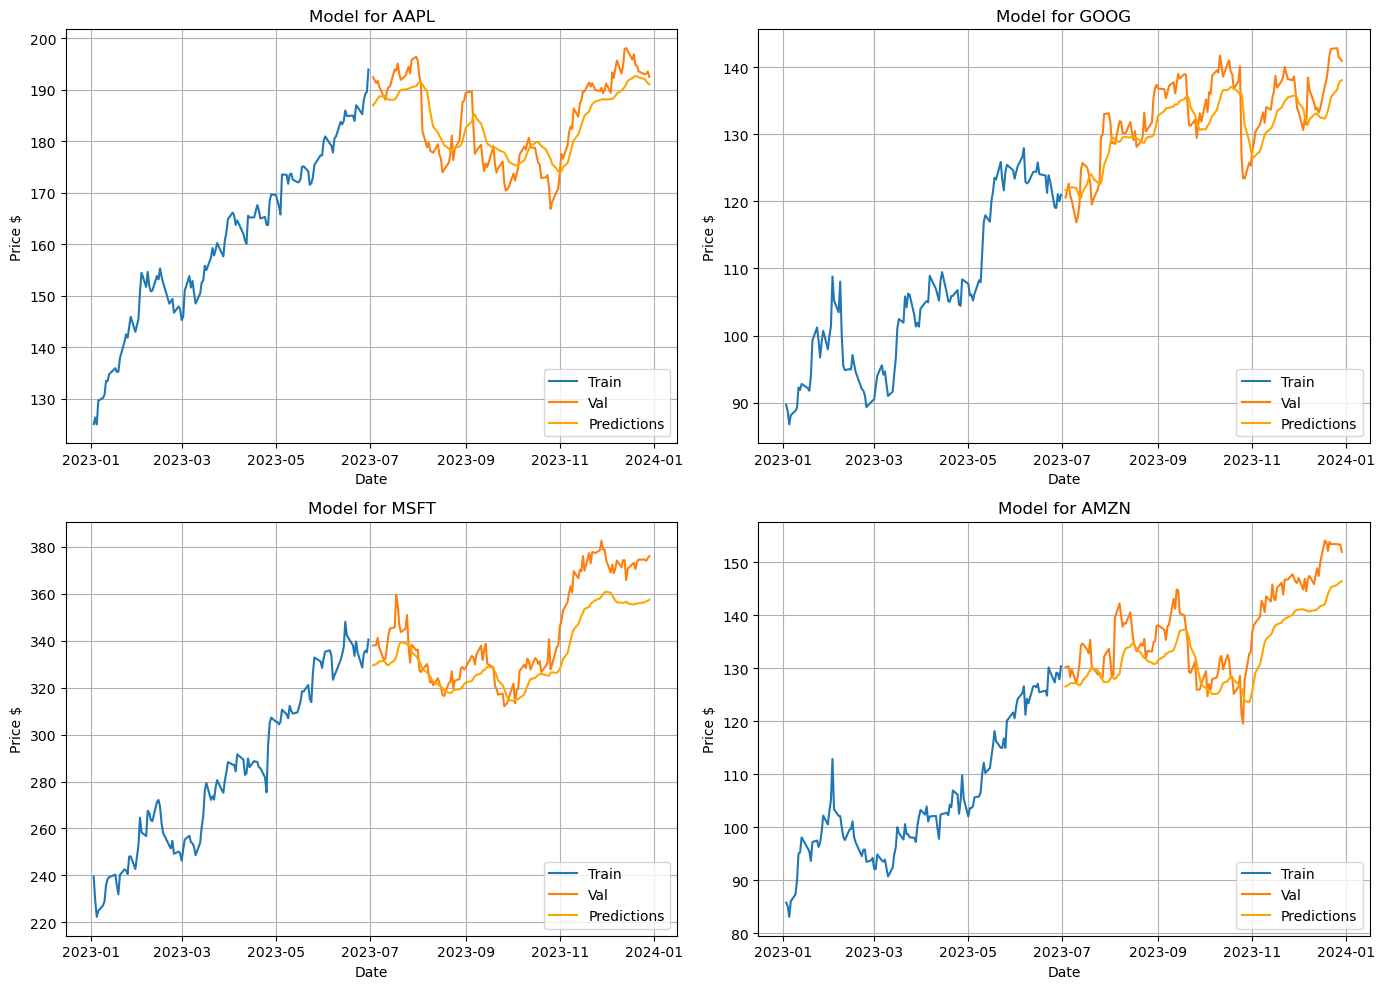

In [8]:
tickers = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
company_names = ['Apple', 'Google', 'Microsoft', 'Amazon']
fig.suptitle('Stock Predictions GRU 2023')
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for i, (ticker, company_name) in enumerate(zip(tickers, company_names)):
    ax = axes[i//2, i%2]
    stock_predict_GRU("2023-01-01", "2023-06-30", ticker, company_name, ax)

plt.tight_layout()
plt.show()

[*********************100%%**********************]  1 of 1 completed
D:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1323/1323 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.0063
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step


[*********************100%%**********************]  1 of 1 completed
D:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1323/1323 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.0059
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step


[*********************100%%**********************]  1 of 1 completed
D:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1323/1323 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0033
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


[*********************100%%**********************]  1 of 1 completed
D:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1323/1323 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.0087
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


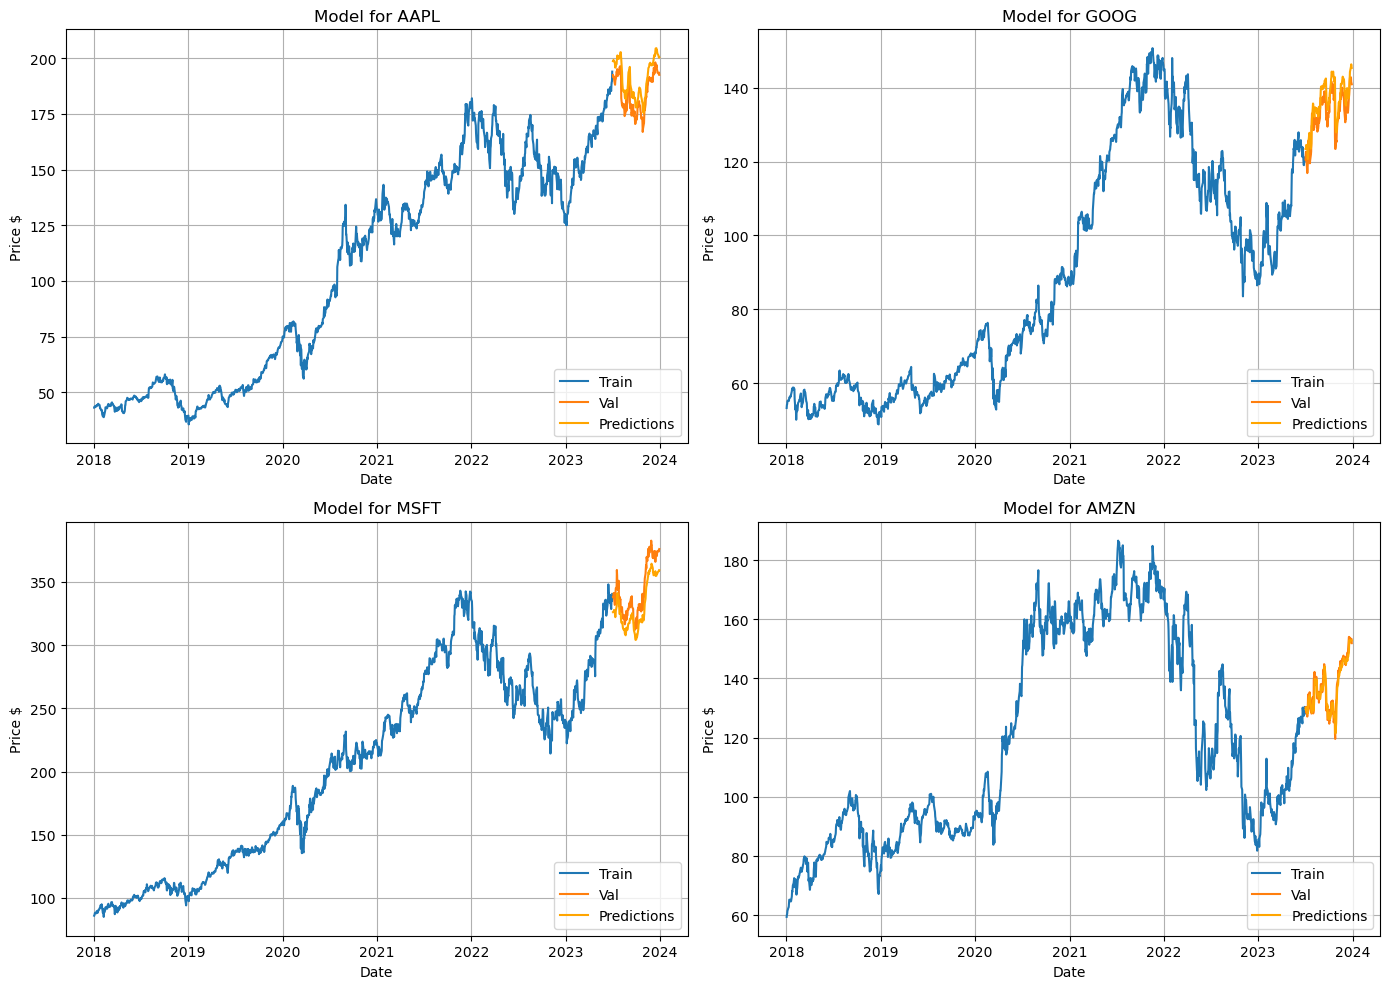

In [9]:
tickers = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
company_names = ['Apple', 'Google', 'Microsoft', 'Amazon']
fig.suptitle('Stock Predictions GRU 2023')
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for i, (ticker, company_name) in enumerate(zip(tickers, company_names)):
    ax = axes[i//2, i%2]
    stock_predict_GRU("2018-01-01", "2023-06-30", ticker, company_name, ax)

plt.tight_layout()
plt.show()

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer

y = df['Close']
X = df.drop(columns=['Close'])  # Assuming other necessary preprocessing is done

# Impute NaN values in X
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor and fit the training data
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Calculate R-squared and Mean Absolute Error
r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
accuracy_percentage = r2 * 100  # Convert R-squared to a percentage

print(f'R-squared: {r2:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Accuracy: {accuracy_percentage:.2f}%')

R-squared: 1.00
Mean Absolute Error: 0.39
Accuracy: 99.95%
